1. Prepare data set

In [41]:
"""
    Grabs data from Microsoft Academic Graph API and data processing
    """
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle
import requests
import itertools
from collections import defaultdict
from time import sleep
import pandas as pd

def get_json():
    """
        send request to Microsoft Academic Graph for information on most citation 1000 papers on data mining
        generates a json file
        """
    url1 = "https://api.labs.cognitive.microsoft.com/academic/v1.0/evaluate?expr=Composite(F.FN='business intelligence')&model=latest&count=1000&offset=1000&attributes=Y,Ti,Id,CC,AA.AuN,AA.AfN,F.FN,W&timeout=5000000"
    headers = {
        "Ocp-Apim-Subscription-Key": "8589fb5697a04eeb8569faed3869480b"  # add own key
    }
    path = "./"
    r = requests.get(url1, headers=headers)
    data = r.json()
    file_name = "bi2.json"
    with open(path+file_name, 'w') as f:
        json.dump(data, f)
    
def create_edge_list():
    """
        creates and pickles the edges list and vertex set
        """
    edge_list = set()
    #conference = set()
    authors = set()
    with open('./bi.json', 'rb') as fp:
        db = json.load(fp)['entities']
        #field test
        for paper in db:
            author_list = [a["AuN"] for a in paper["AA"]]
            edges = list(itertools.combinations(author_list, 2))
            year = [paper['Y']]*len(edges)
            edge_year = list(zip(edges, year))
            authors.update(author_list)
            edge_list.update(edge_year)

    with open("edges_bi.p", 'wb') as f:
        pickle.dump(edge_list, f)
    with open("authors_bi.p", 'wb') as f:
        pickle.dump(authors, f)

def get_edge_weights():
    """
    for each edge, the weight is the number of collaborations done between the two authors
    """
    with open("./edges_bi.p", 'rb') as f1:
        edges = pickle.load(f1)

    edge1 = [x[0] for x in edges]
    weights = defaultdict(lambda: 0)
    for edge in edge1:
        weights[edge] += 1

    w = dict(weights)

    with open("./weights_bi.p", 'wb') as f:
        pickle.dump(w, f)

In [22]:
#get_json()
#create_edge_list()

Name: 
Type: Graph
Number of nodes: 211
Number of edges: 3423
Average degree:  32.4455


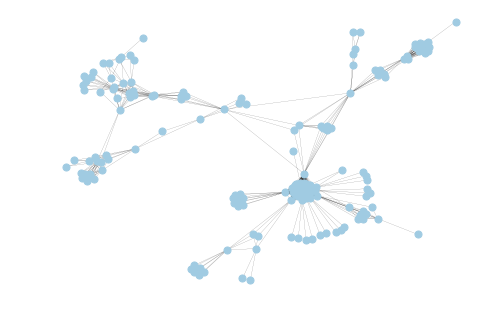

In [88]:
class Graph_Whole(object):
    def __init__(self,edge,node,w):
        self.train = nx.Graph()
        #self.test = nx.Graph()
        for (node1, node2), year in edge:
            weightEdge = 1 / w[(node1, node2)]
            self.train.add_edge(node1, node2, weight = weightEdge )
        
        self.train = max(nx.connected_component_subgraphs(self.train), key=len)
options = {
    'node_color': '#A0CBE2',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 1,
    'width': 0.1,
}

node = pickle.load( open("authors_bi.p","rb") )
edge = pickle.load( open("edges_bi.p","rb"))
w = pickle.load( open("weights_bi.p", "rb"))
dataGraph = Graph_Whole(edge,node,w)
print(nx.info(dataGraph.train))
pickle.dump(dataGraph.train, open('graph_data.p', "wb"))
nx.draw(dataGraph.train, **options)
plt.show()

In [57]:
# Ti,AA.AuN,W,F.FN
def node_attributes(authorlist=None):
    """
    for every author in the author list, gets information on the number of collaborations, list of keywords,
    list of fields he/she has worked in, and number of papers published
    creates a json file to store data
    """
    if authorlist is None:
        with open("./train_authors.p", 'rb') as f:
            authors = pickle.load(f)
    else:
        authors = authorlist
    
    with open('./attributes_bi.json', 'r') as f:
        attributes = json.load(f)
    #attributes = {}
    counter = 0
    for i, author in enumerate(authors):
        if author in attributes.keys():
            print(str(author) + " was skipped because info was already found")
            continue
        counter += 1
        url = "https://api.labs.cognitive.microsoft.com/academic/v1.0/calchistogram?expr=Composite(AA.AuN=='%s')" \
              "&model=latest&attributes=Ti,AA.AuN,AA.AfN,F.FN,W&count=100&offset=0" % author
        headers = {
            "Ocp-Apim-Subscription-Key": "69c87ea52efe4e268081f12e50909026"  # add own key
        }
        r = requests.get(url, headers=headers)
        print("round " + str(i) + " r: " + str(r))
        d = r.json()
        data = d['histograms']
        attributes[author] = dict()
        for entry in data:
            if entry["attribute"] == "Ti":
                num_papers = entry["distinct_values"]
                attributes[author]["num_papers"] = num_papers
            elif entry["attribute"] == "AA.AfN":
                num_coafs = entry["distinct_values"]
                attributes[author]["num_affilication"] = num_coafs
            elif entry["attribute"] == "W":
                keywords = list(set([e["value"] for e in entry["histogram"]]))
                attributes[author]["keywords"] = keywords
            else:
                #assert entry["attribute"] == "F.FN", "attribute type is not field"
                entry["attribute"] == "F.FN"
                fields = list(set([e["value"] for e in entry["histogram"]]))
                attributes[author]["fields"] = fields
        if counter == 20:
            print("writing to file")
            counter = 0
            with open("./attributes_bi.json", 'w') as f:
                json.dump(attributes, f)
        sleep(10)

    with open("./attributes_bi.json", 'w') as f:
        json.dump(attributes, f)


node_attributes(dataGraph.train.node)

barbara weber was skipped because info was already found
jan mendling was skipped because info was already found
w m p van der aalst was skipped because info was already found
sukriti goel was skipped because info was already found
florian waas was skipped because info was already found
boudewijn f van dongen was skipped because info was already found
magdalena kostoska was skipped because info was already found
alkis simitsis was skipped because info was already found
janet l wiener was skipped because info was already found
evellin cardoso was skipped because info was already found
yuchun xu was skipped because info was already found
irene barba was skipped because info was already found
wey guy was skipped because info was already found
minseok song was skipped because info was already found
ricardo seguel perez was skipped because info was already found
schahram dustdar was skipped because info was already found
peter van den brand was skipped because info was already found
a k alv

In [41]:
from tqdm import tqdm
import pickle
# from graph import Graph
import json
import networkx as nx
import numpy as np
from sklearn import preprocessing
class Metrics(object):

    def __init__(self, train,path_feature = False):
        self.train = train
        #self.test = test
        self.info = json.load(open("attributes_bi.json"))
        if path_feature:
            self.shortest_path = dict(nx.floyd_warshall(train, weight = 'weight'))

    def path(self, node1, node2):
        if(nx.has_path(self.train,node1,node2)):
            return self.shortest_path[node1][node2]
        else:
            return 99999

    def sum_affilication_count(self, node1, node2):
        return self.info[node1]["num_affilication"] + self.info[node2]["num_affilication"]

    def sum_neighbors_count(self, node1, node2):
        return len(list(self.train.neighbors(node1))) + len(list(self.train.neighbors(node2)))
    
    def sum_paper_count(self, node1, node2):
        return self.info[node1]["num_papers"] + self.info[node2]["num_papers"]


    #number of common_neighbors
    def common_neighbors(self, node1, node2):
        node1_neighbors = set()
        node2_neighbors = set()
        for n1 in self.train.neighbors(node1):
            node1_neighbors.add(n1)


        for n2 in self.train.neighbors(node2):
            node2_neighbors.add(n2)


        #print([node for node in node1_neighbors if node in node2_neighbors])
        return len(node1_neighbors.intersection(node2_neighbors))
    
    #Jaccard's coefficient
    def jaccard_coefficient(self, node1, node2):
        common_neighbors = self.common_neighbors(node1, node2)
        sum_neighbors_count = self.sum_neighbors_count(node1, node2)
        return common_neighbors/(sum_neighbors_count-common_neighbors)
    
    def preferential_attachment(self, node1, node2):
        node1_neighbors = set()
        node2_neighbors = set()
        for n1 in self.train.neighbors(node1):
            node1_neighbors.add(n1)
        for n2 in self.train.neighbors(node2):
            node2_neighbors.add(n2)    
        
        return len(node1_neighbors)*len(node2_neighbors)
    
    
    #degree of matching key_words
    def key_words_match(self, node1, node2):
        node1_words = self.info[node1]["keywords"]
        node2_words = self.info[node2]["keywords"]

        hit = 0
        for word1 in node1_words:
            for word2 in node2_words:
                if word1 == word2:
                    hit+=1
        return hit

    #degree of matching for fields
    def fields_match(self, node1, node2):
        node1_words = self.info[node1]["fields"]
        node2_words = self.info[node2]["fields"]

        hit = 0 
        for i in range(len(node1_words)):
            for j in range(i+1, len(node2_words)):
                if node1_words[i] == node2_words[j]:
                    hit+=1
        return hit



In [65]:

if __name__ == "__main__":
    dataGraph = pickle.load(open("graph_data.p", "rb"))
    metric = Metrics(dataGraph.train, path_feature = True)
    data = []
    labels = []
#     test_data = []
#     test_labels = []
    df = pd.DataFrame(columns=['Shortest Path', 'Keyword Match Count', 'Field Match Count', 'Common Neighbor', 'Sum of Affilication', 'Sum of Neighbor', 'Sum of Paper', 'Jaccard Coefficient','Preferential Attachment','Label'])
    index = 0
    for node1 in tqdm(dataGraph.train):
        for node2 in dataGraph.train:
            #Toplogical features
            #calculate path
            path_score = metric.path(node1, node2)
            #neighbors 
            neighbor_score = metric.common_neighbors(node1, node2)     
            #Jaccard_coefficient score
            jac = metric.jaccard_coefficient(node1, node2)
            pa =metric.preferential_attachment(node1,node2)    
            
            #proximity features
            key_score = metric.key_words_match(node1, node2)
            field_score = metric.fields_match(node1, node2)
                
            #aggregated feartures
            aSum = metric.sum_affilication_count(node1, node2)
            nSum = metric.sum_neighbors_count(node1, node2)
            pSum = metric.sum_paper_count(node1, node2)
                
            
            data.append([path_score, key_score, field_score, neighbor_score, aSum, nSum, pSum, jac, pa])

            if (node1, node2) not in dataGraph.train.edges and node1 != node2:
                label=0
                #cn.append(neighbor_score,0)
            else:
                label=1
                #cn.append(neighbor_score,1)
            df=df.append(pd.DataFrame({'Shortest Path':[path_score], 'Keyword Match Count':[key_score], 'Field Match Count':[field_score], 'Common Neighbor':[neighbor_score], 'Sum of Affilication':[aSum], 'Sum of Neighbor':[nSum], 'Sum of Paper':[pSum], 'Jaccard Coefficient':[jac],'Preferential Attachment':[pa],'Label':[label]}),ignore_index=True)
            labels.append(label)
            index +=1
            
            
    X_train = np.array(data)
    X_reduce_train = X_train[:, [0, 1, 2]]
    X_scaled_train = preprocessing.scale(X_reduce_train)

#     X_test = np.array(test_data)
#     X_reduce_test = X_test[:, [0, 1, 2]]
#     X_scaled_test = preprocessing.scale(X_reduce_test)


    pickle.dump( X_train, open("X_train.p", "wb"))
    pickle.dump( X_scaled_train, open("X_scaled_train.p", "wb"))
#     pickle.dump( X_test, open("X_test.p", "wb"))
#     pickle.dump( X_scaled_test, open("X_scaled_test.p", "wb"))
    pickle.dump( labels, open("labels.p", "wb"))
#     pickle.dump( test_labels, open("test_labels.p", "wb"))

100%|██████████| 211/211 [11:18<00:00,  5.86s/it]


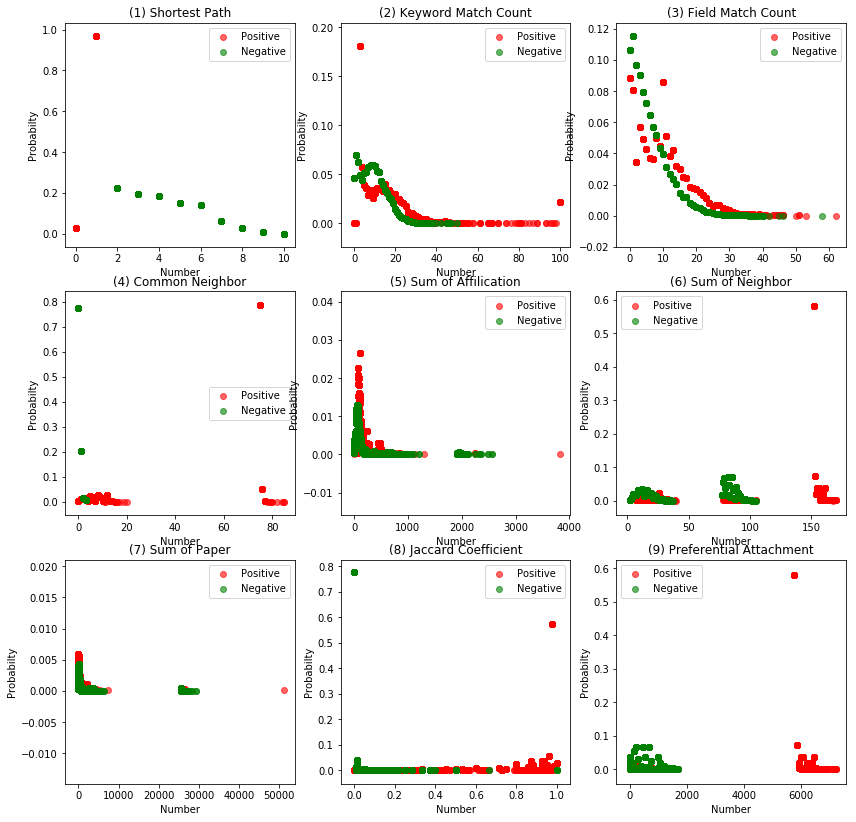

In [66]:
import matplotlib.pyplot as plt
y1=[]
y2=[]
index = 1
plt.figure(figsize=(14, 14))
for col in df.columns:
    if col!='Label':
        x1 = df.loc[df.Label == 1 ,col]
        x2 = df.loc[df.Label == 0 ,col]
        n1 = x1.groupby(df[col]).count()
        n2 = x2.groupby(df[col]).count()
        for i in x1:
            i = n1[i]/sum(n1)
            y1.append(i)
        for i in x2:
            i = n2[i]/sum(n2)
            y2.append(i)
        plt.subplot(3,3,index)
        plt.title("(" + str(index) + ") " + col)
        plt.scatter(x1,y1, c='red', label='Positive', alpha=0.6)
        plt.scatter(x2,y2, c='green', label='Negative', alpha=0.6)
        plt.xlabel("Number") #X轴标签
        plt.ylabel("Probabilty")  #Y轴标签
        plt.legend()
        index += 1
        y1=[]
        y2=[]
plt.show()

Name: 
Type: Graph
Number of nodes: 156
Number of edges: 3189
Average degree:  40.8846


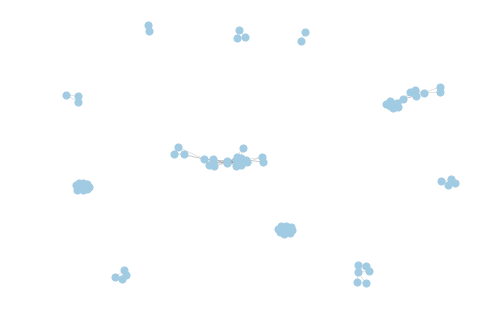

In [38]:
class Graph(object):

    def __init__(self, edges, author, w, dgraph, trainingSet, testingSet):
        self.train = nx.Graph()
        self.test = nx.Graph()
        for (n1, n2) in dgraph.edges:         
            for (node1, node2), year in edges:
                weightEdge = 1 / w[(node1, node2)]
                if(n1==node1 and n2==node2 and n1!=n2):
                    if year >=trainingSet[0] and year <=trainingSet[1]:
                        self.train.add_edge(node1, node2, weight = weightEdge )
                    elif year >=testingSet[0] and year <=testingSet[1]:
                        self.test.add_edge(node1, node2, weight = weightEdge)
                elif(n1==node2 and n2==node1 and n1!=n2):
                    if year >=trainingSet[0] and year <=trainingSet[1]:
                        self.train.add_edge(node1, node2, weight = weightEdge )
                    elif year >=testingSet[0] and year <=testingSet[1]:
                        self.test.add_edge(node1, node2, weight = weightEdge)
		#self.train = max(nx.connected_component_subgraphs(self.train), key=len)
		#self.test = max(nx.connected_component_subgraphs(self.test), key=len)




options = {
'node_color': '#A0CBE2',
'node_size': 50,
'line_color': 'grey',
'linewidths': 1,
'width': 0.1,
}

edges = pickle.load( open("edges_bi.p", "rb"))
authors = pickle.load( open("authors_bi.p", "rb"))
w = pickle.load( open("weights_bi.p", "rb"))
dg = pickle.load(open("graph_data.p", "rb"))
dataGraph1 = Graph(edges, authors, w, dg, [1967, 2012], [2013, 2019])
print (nx.info(dataGraph1.train))
pickle.dump(dataGraph1, open('graph_data1.p', "wb"))
nx.draw(dataGraph1.test, **options)
plt.show()

In [39]:
print (nx.info(dataGraph1.test))
dg = pickle.load(open("graph_data.p", "rb"))
print(len(dg.edges))

Name: 
Type: Graph
Number of nodes: 79
Number of edges: 241
Average degree:   6.1013
3423


In [42]:
dataGraph = pickle.load(open("graph_data1.p", "rb"))
metric = Metrics(dataGraph.train, path_feature = True)
metric2 = Metrics(dataGraph.test, path_feature = True)
data = []
labels = []
test_data = []
test_labels = []
#df = pd.DataFrame(columns=['Shortest Path', 'Keyword Match Count', 'Field Match Count', 'Common Neighbor', 'Sum of Affilication', 'Sum of Neighbor', 'Sum of Paper', 'Jaccard Coefficient','Preferential Attachment','Label'])
index = 0
for node1 in tqdm(dataGraph.train):
    for node2 in dataGraph.train:
        #Toplogical features
        #calculate path
        path_score = metric.path(node1, node2)
        #neighbors 
        neighbor_score = metric.common_neighbors(node1, node2)     
        #Jaccard_coefficient score
        jac = metric.jaccard_coefficient(node1, node2)
        pa =metric.preferential_attachment(node1,node2)    

        #proximity features
        key_score = metric.key_words_match(node1, node2)
        field_score = metric.fields_match(node1, node2)

        #aggregated feartures
        aSum = metric.sum_affilication_count(node1, node2)
        nSum = metric.sum_neighbors_count(node1, node2)
        pSum = metric.sum_paper_count(node1, node2)


        data.append([path_score, key_score, field_score, neighbor_score, aSum, nSum, pSum, jac, pa])

        if (node1, node2) not in dataGraph.train.edges and node1 != node2:
            label=0
            #cn.append(neighbor_score,0)
        else:
            label=1
            #cn.append(neighbor_score,1)
        #df=df.append(pd.DataFrame({'Shortest Path':[path_score], 'Keyword Match Count':[key_score], 'Field Match Count':[field_score], 'Common Neighbor':[neighbor_score], 'Sum of Affilication':[aSum], 'Sum of Neighbor':[nSum], 'Sum of Paper':[pSum], 'Jaccard Coefficient':[jac],'Preferential Attachment':[pa],'Label':[label]}),ignore_index=True)
        labels.append(label)
        index +=1


X_train = np.array(data)
#X_reduce_train = X_train[:, [0, 1, 2]]
#X_scaled_train = preprocessing.scale(X_reduce_train)
X_scaled_train = preprocessing.scale(X_train)
index = 0
for node1 in tqdm(dataGraph.test):
    for node2 in dataGraph.test:
        #Toplogical features
        #calculate path
        path_score = metric2.path(node1, node2)
        #neighbors 
        neighbor_score = metric2.common_neighbors(node1, node2)     
        #Jaccard_coefficient score
        jac = metric2.jaccard_coefficient(node1, node2)
        pa =metric2.preferential_attachment(node1,node2)    

        #proximity features
        key_score = metric2.key_words_match(node1, node2)
        field_score = metric2.fields_match(node1, node2)

        #aggregated feartures
        aSum = metric2.sum_affilication_count(node1, node2)
        nSum = metric2.sum_neighbors_count(node1, node2)
        pSum = metric2.sum_paper_count(node1, node2)


        test_data.append([path_score, key_score, field_score, neighbor_score, aSum, nSum, pSum, jac, pa])

        if (node1, node2) not in dataGraph.test.edges and node1 != node2:
            label=0
            #cn.append(neighbor_score,0)
        else:
            label=1
            #cn.append(neighbor_score,1)
        #df=df.append(pd.DataFrame({'Shortest Path':[path_score], 'Keyword Match Count':[key_score], 'Field Match Count':[field_score], 'Common Neighbor':[neighbor_score], 'Sum of Affilication':[aSum], 'Sum of Neighbor':[nSum], 'Sum of Paper':[pSum], 'Jaccard Coefficient':[jac],'Preferential Attachment':[pa],'Label':[label]}),ignore_index=True)
        test_labels.append(label)
        index +=1



X_test = np.array(test_data)
#X_reduce_test = X_test[:, [0, 1, 2]]
#X_scaled_test = preprocessing.scale(X_reduce_test)
X_scaled_test = preprocessing.scale(X_test)

pickle.dump( X_train, open("X_train.p", "wb"))
pickle.dump( X_scaled_train, open("X_scaled_train.p", "wb"))
pickle.dump( X_test, open("X_test.p", "wb"))
pickle.dump( X_scaled_test, open("X_scaled_test.p", "wb"))
pickle.dump( labels, open("labels.p", "wb"))
pickle.dump( test_labels, open("test_labels.p", "wb"))

100%|██████████| 79/79 [00:03<00:00, 21.40it/s]


100%|██████████| 6241/6241 [00:06<00:00, 892.22it/s] 
/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Features sorted by scores
[(0.387,), (0.2034,), (0.1775,), (0.1244,), (0.0886,), (0.0181,), (0.0008,), (0.0001,), (0.0001,)]


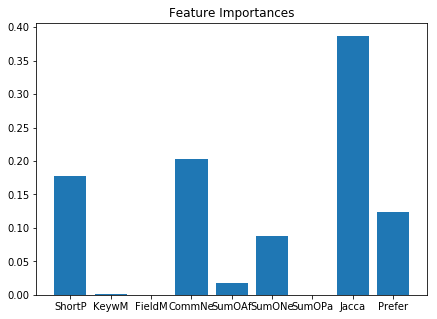

In [53]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib

class Feature_rank(object):

	def __init__(self, train_data, train_labels, test_data, test_labels):
		self.train_data = train_data
		self.train_labels = train_labels
		self.test_data = test_data
		self.test_labels = test_labels



	def rf(self):

		clf = RandomForestClassifier(n_estimators= 20, max_depth=7, random_state=0, min_samples_leaf=20)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])

		print ("Features sorted by scores")
		print (sorted(zip(map(lambda x: round(x,4),clf.feature_importances_)),reverse = True))
		f, ax = plt.subplots(figsize=(7, 5))
		ax.bar(range(len(clf.feature_importances_)),clf.feature_importances_)
		ax.set_xticks([0,1, 2, 3, 4, 5, 6, 7, 8])
		#ax.set_xticks([1, 2, 3, 4, 5])ax.set_xticklabels([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$'], fontsize=18)

		ax.set_xticklabels( ['ShortP', 'KeywM', 'FieldM', 'CommNe', 'SumOAf','SumONe','SumOPa','Jacca','Prefer'] )        
		ax.set_title("Feature Importances")
		f.show()
if __name__ == "__main__":
	test_labels = pickle.load( open ("test_labels.p", "rb"))
	test_data = pickle.load( open ("X_scaled_test.p", "rb"))
	train_labels = pickle.load( open ("labels.p", "rb"))
	train_data = pickle.load( open ("X_scaled_train.p", "rb"))

	fr = Feature_rank(train_data, train_labels, test_data, test_labels)
	fr.rf()



100%|██████████| 6241/6241 [00:00<00:00, 11718.91it/s]


0.9101105592052555
[[5680    0]
 [ 561    0]]
[LibSVM]

 53%|█████▎    | 3310/6241 [00:00<00:00, 33099.64it/s]

0.9421567056561448
[[5323  357]
 [   4  557]]


100%|██████████| 6241/6241 [00:00<00:00, 27867.96it/s]


0.8258291940394168
[[4593 1087]
 [   0  561]]


  4%|▍         | 255/6241 [00:00<00:02, 2545.50it/s]

0.9381509373497837
[[5294  386]
 [   0  561]]


  4%|▍         | 273/6241 [00:00<00:02, 2726.10it/s]

0.9623457779202051
[[5459  221]
 [  14  547]]


  4%|▎         | 232/6241 [00:00<00:02, 2317.01it/s]

0.9649094696362762
[[5475  205]
 [  14  547]]


  0%|          | 0/6241 [00:00<?, ?it/s]

0.9674731613523474
[[5493  187]
 [  16  545]]


100%|██████████| 6241/6241 [00:06<00:00, 914.64it/s] 


[[1784 3896]
 [   0  561]]
[1.77523436e-01 7.87072084e-04 6.06562517e-05 2.03357190e-01
 1.81193835e-02 8.86264533e-02 7.86253085e-05 3.87029222e-01
 1.24417961e-01]


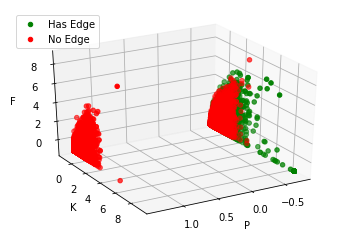

In [44]:
import networkx as nx
import pickle
from tqdm import tqdm
from sklearn import svm
from sklearn.metrics import confusion_matrix
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import time
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
class Model(object):

	def __init__(self, train_data, train_labels, test_data, test_labels):
		self.train_data = train_data
		self.train_labels = train_labels
		self.test_data = test_data
		self.test_labels = test_labels


	def random_forest(self):

		#15 6

		#20 7
		clf = RandomForestClassifier(n_estimators= 20, max_depth=7, random_state=0, min_samples_leaf=20)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])

		print (confusion_matrix(self.test_labels, y_pred))
		print (clf.feature_importances_)
		return clf.feature_importances_
    
	def svm_linear(self):

		clf = svm.LinearSVC(random_state = 0, tol=1e-5)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))



	def svm_kernel(self):

		clf = svm.SVC(random_state = 0, verbose = True)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))


	def adaBoost(self):

		clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=20)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))

	def knn_3(self):
		clf = KNeighborsClassifier(n_neighbors=3)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
        
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))

	def knn_5(self):
		clf = KNeighborsClassifier(n_neighbors=5)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))
        
	def knn_7(self):
		clf = KNeighborsClassifier(n_neighbors=7)
		#clf = svm.SVC()
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))
        
	def naive_bayes(self):
		clf = GaussianNB()
		#clf = svm.SVC()
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))


if __name__ == "__main__":
	test_labels = pickle.load( open ("test_labels.p", "rb"))
	test_data = pickle.load( open ("X_scaled_test.p", "rb"))
	train_labels = pickle.load( open ("labels.p", "rb"))
	train_data = pickle.load( open ("X_scaled_train.p", "rb"))

	model = Model(train_data, train_labels, test_data, test_labels)
	model.naive_bayes()
	model.svm_kernel()
	model.svm_linear()
	model.adaBoost()
	model.knn_3()
	model.knn_5()
	model.knn_7()
	model.random_forest()

	positive = []
	negative = []
	for train, label in zip(train_data, train_labels):
		if label == 1:
			positive.append(train)
		else:
			negative.append(train)

	positive = np.array(positive)
	negative = np.array(negative)
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(positive[:,0], positive[:,1], positive[:,2], c="green", label ="Has Edge")
	ax.scatter(negative[:,0], negative[:,1], negative[:,2], c="red", label = "No Edge")
	plt.legend(loc = "upper left")
	ax.set_xlabel('P')
	ax.set_ylabel('K')
	ax.set_zlabel('F')
	ax.view_init(azim=60)
	fig.savefig("test.png")

100%|██████████| 2304/2304 [00:00<00:00, 11627.20it/s]


0.9036458333333334
[[2082    0]
 [ 222    0]]
[LibSVM]

100%|██████████| 2304/2304 [00:00<00:00, 13189.62it/s]


0.9283854166666666
[[2082    0]
 [ 165   57]]


  0%|          | 0/2304 [00:00<?, ?it/s]

0.9878472222222222
[[2054   28]
 [   0  222]]


 16%|█▌        | 359/2304 [00:00<00:00, 3585.81it/s]

0.9878472222222222
[[2054   28]
 [   0  222]]


 15%|█▍        | 340/2304 [00:00<00:00, 3399.70it/s]

0.9557291666666666
[[2075    7]
 [  95  127]]


 14%|█▍        | 334/2304 [00:00<00:00, 3333.70it/s]

0.9427083333333334
[[2079    3]
 [ 129   93]]


  0%|          | 0/2304 [00:00<?, ?it/s]

0.9375
[[2081    1]
 [ 143   79]]


100%|██████████| 2304/2304 [00:02<00:00, 880.99it/s]


[[2054   28]
 [   0  222]]
[0.78412832 0.1980841  0.01778758]


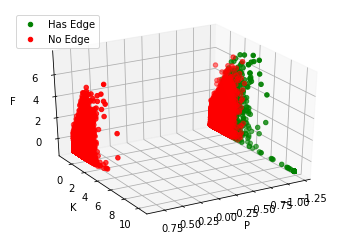

In [45]:
import networkx as nx
import pickle
from tqdm import tqdm
from sklearn import svm
from sklearn.metrics import confusion_matrix
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import time
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
class Model(object):

	def __init__(self, train_data, train_labels, test_data, test_labels):
		self.train_data = train_data
		self.train_labels = train_labels
		self.test_data = test_data
		self.test_labels = test_labels


	def random_forest(self):

		#15 6

		#20 7
		clf = RandomForestClassifier(n_estimators= 20, max_depth=7, random_state=0, min_samples_leaf=20)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])

		print (confusion_matrix(self.test_labels, y_pred))
		print (clf.feature_importances_)
		return clf.feature_importances_
    
	def svm_linear(self):

		clf = svm.LinearSVC(random_state = 0, tol=1e-5)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))



	def svm_kernel(self):

		clf = svm.SVC(random_state = 0, verbose = True)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))


	def adaBoost(self):

		clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=20)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))

	def knn_3(self):
		clf = KNeighborsClassifier(n_neighbors=3)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
        
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))

	def knn_5(self):
		clf = KNeighborsClassifier(n_neighbors=5)
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))
        
	def knn_7(self):
		clf = KNeighborsClassifier(n_neighbors=7)
		#clf = svm.SVC()
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))
        
	def naive_bayes(self):
		clf = GaussianNB()
		#clf = svm.SVC()
		clf.fit(self.train_data, self.train_labels)
		y_pred = []
		for query in tqdm(self.test_data):
			y_pred.append(clf.predict([query])[0])
		accuracy = clf.score(self.test_data, self.test_labels)
		print(accuracy)
		print (confusion_matrix(self.test_labels, y_pred))


if __name__ == "__main__":
	test_labels = pickle.load( open ("dm_test_labels.p", "rb"))
	test_data = pickle.load( open ("dm_X_scaled_test.p", "rb"))
	train_labels = pickle.load( open ("dm_labels.p", "rb"))
	train_data = pickle.load( open ("dm_X_scaled_train.p", "rb"))

	model = Model(train_data, train_labels, test_data, test_labels)
	model.naive_bayes()
	model.svm_kernel()
	model.svm_linear()
	model.adaBoost()
	model.knn_3()
	model.knn_5()
	model.knn_7()
	model.random_forest()

	positive = []
	negative = []
	for train, label in zip(train_data, train_labels):
		if label == 1:
			positive.append(train)
		else:
			negative.append(train)

	positive = np.array(positive)
	negative = np.array(negative)
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(positive[:,0], positive[:,1], positive[:,2], c="green", label ="Has Edge")
	ax.scatter(negative[:,0], negative[:,1], negative[:,2], c="red", label = "No Edge")
	plt.legend(loc = "upper left")
	ax.set_xlabel('P')
	ax.set_ylabel('K')
	ax.set_zlabel('F')
	ax.view_init(azim=60)